In [2]:
import pymysql
import pickle
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='AppleGothic')
import seaborn as sns
from tqdm import tqdm
import googlemaps
import folium
import geopy
from geopy.geocoders import Nominatim
import geopandas
pw_path = '/Users/johanjun/🔐/'

# DB Connection

In [17]:
with open(str(pw_path)+'seoul_bike_sharing.pkl', 'rb') as f:
    info = pickle.load(f)

In [18]:
db = pymysql.connect(
    user=info['ID'], 
    password=info['PW'], 
    host=info['Host'], 
    database=info['DB'],
    port=info['Port'],
    charset='utf8', ssl={"fake_flag_to_enable_tls":True}
)

In [19]:
cursor = db.cursor(pymysql.cursors.DictCursor)

In [20]:
sql = "SELECT * FROM `station`"
cursor.execute(sql)
result = cursor.fetchall()

In [21]:
len(result)

2242

In [22]:
result[0]

{'station_no': 102,
 'station_name': '102. 망원역 1번출구 앞',
 'station_id': 'ST-4',
 'longitude': '126.91062927',
 'latitude': '37.55564880',
 'SeCd': 'RAK_001'}

# pickle open

In [24]:
# df_station_info = pd.DataFrame(result)

In [26]:
# with open('/Users/johanjun/Documents/data/df_station_info_210610.pkl', 'wb') as f:
#     pickle.dump(df_station_info, f)

In [4]:
with open('/Users/johanjun/Documents/data/df_seoul_bike_sharing_210608.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
df.head()

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour
0,2021-01-01,0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,~10대,2,28.90,0.23,992.78,13
1,2021-01-01,0,1349,1349. 월계2교 버스정류장 앞,정기권,,~10대,1,34.38,0.26,1127.50,10
2,2021-01-01,0,1168,1168. 마곡엠밸리10단지 앞,정기권,,~10대,1,0.00,0.00,0.00,7
3,2021-01-01,0,2619,2619. 석촌고분역 4번출구,정기권,,~10대,1,38.75,0.38,1658.34,14
4,2021-01-01,0,536,536. 행당역 2번출구 앞,정기권,,~10대,1,12.96,0.17,743.88,5


In [5]:
df.shape

(718857, 12)

# EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718857 entries, 0 to 718856
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   rent_date     718857 non-null  object 
 1   rent_hour     718857 non-null  int64  
 2   station_no    718857 non-null  int64  
 3   station_name  718857 non-null  object 
 4   rent_type     718857 non-null  object 
 5   sex           718857 non-null  object 
 6   age_type      718857 non-null  object 
 7   rent_count    718857 non-null  int64  
 8   momentum      718857 non-null  float64
 9   green         718857 non-null  float64
 10  distance      718857 non-null  float64
 11  use_hour      718857 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 65.8+ MB


## metadata

1. rent_date : 대여 일자
2. rent_hour : 대여 시간
3. station_no : 대여소 번호(상세 데이터 필요)
4. station_name : 대여소명(지리 데이터로 변환?)
5. rent_type : 대여구분코드 (일일권, 정기권, 단체권, 일일권비회원)
6. sex : 성별(F, M - 가입회원 기준이라면 실제 성별과 일치하지 않을 수 있음)
7. age_type : 연령대코드 (20대 등)
8. rent_count : 이용건수 (같은 대여소에 동일한 성별, 연령대가 2명이상이 빌리면 합산되어 표기됨)
9. momentum : 운동량 (단위 알 수 없음)
10. green : 탄소량 (단위 알 수 없음)
11. distance : 이동거리 (m)
12. use_hour : 사용시간 (단위 시)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1080x1080 with 0 Axes>

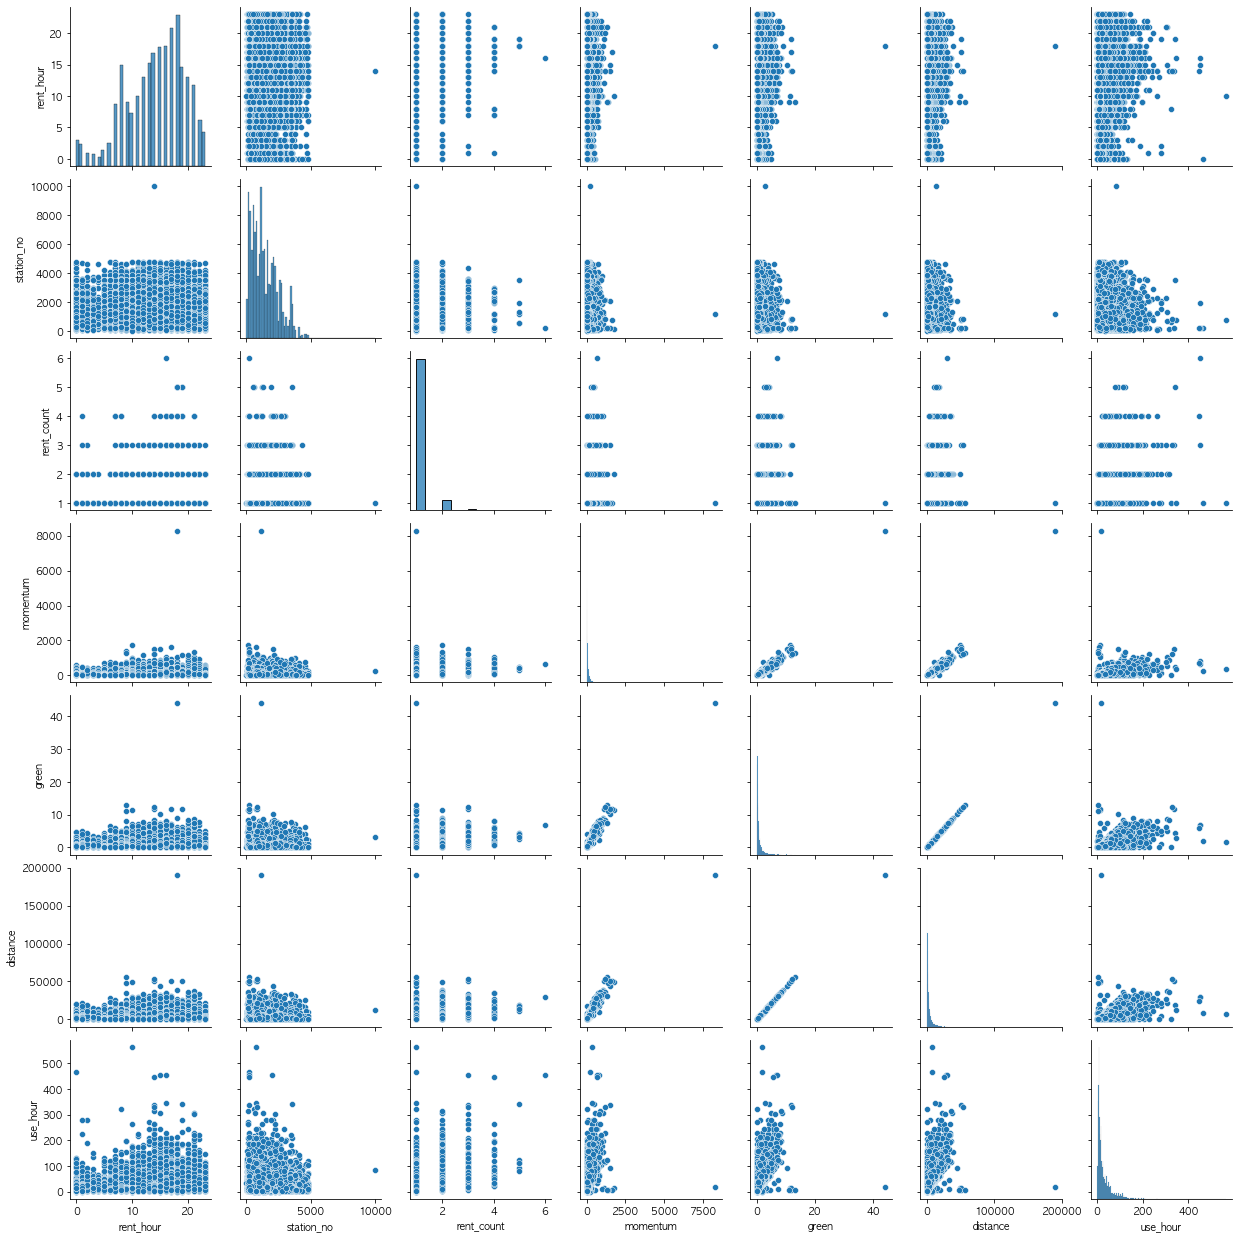

In [173]:
plt.figure(figsize=(15, 15))
sns.pairplot(df.sample(n=15000))
plt.show

## missing data

- 결측치 없음

<AxesSubplot:>

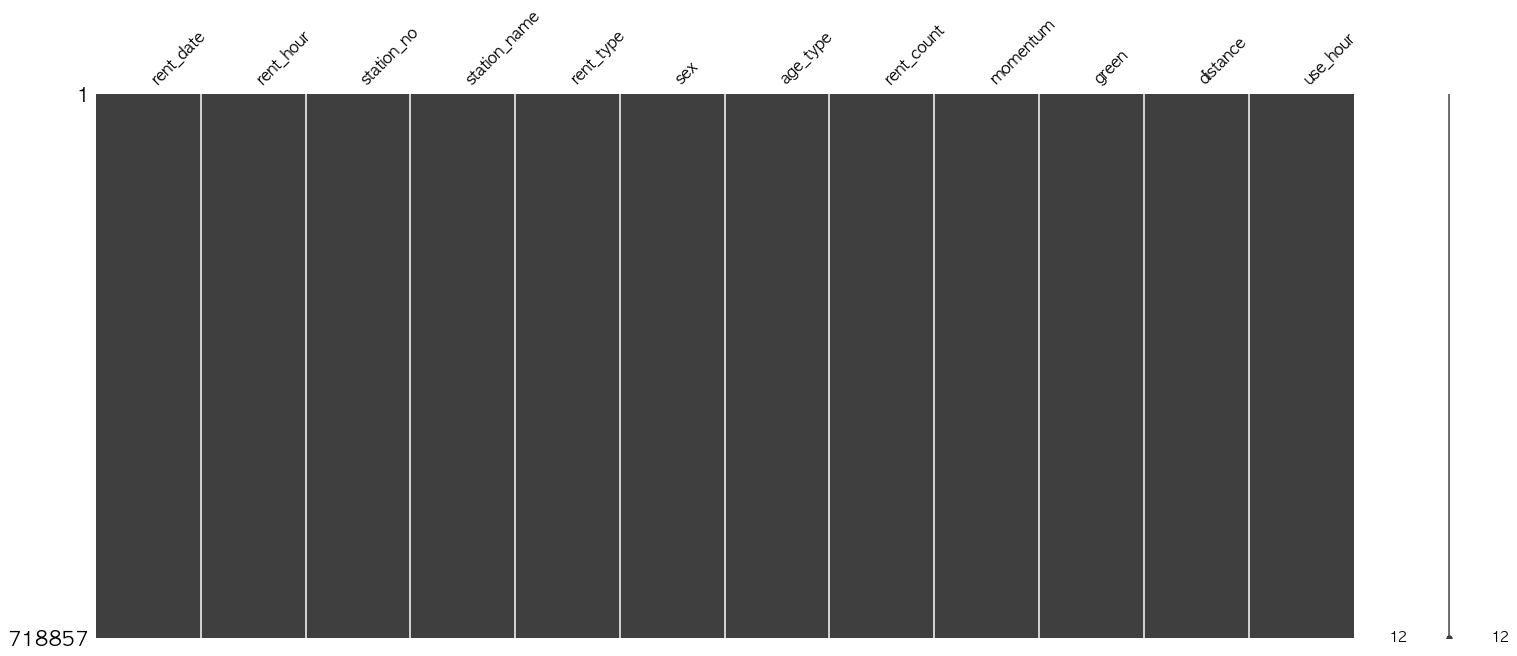

In [17]:
msno.matrix(df=df)

## data explore

### rent_date

In [18]:
df.rent_date =pd.to_datetime(df.rent_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718857 entries, 0 to 718856
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   rent_date     718857 non-null  datetime64[ns]
 1   rent_hour     718857 non-null  int64         
 2   station_no    718857 non-null  int64         
 3   station_name  718857 non-null  object        
 4   rent_type     718857 non-null  object        
 5   sex           718857 non-null  object        
 6   age_type      718857 non-null  object        
 7   rent_count    718857 non-null  int64         
 8   momentum      718857 non-null  float64       
 9   green         718857 non-null  float64       
 10  distance      718857 non-null  float64       
 11  use_hour      718857 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 65.8+ MB


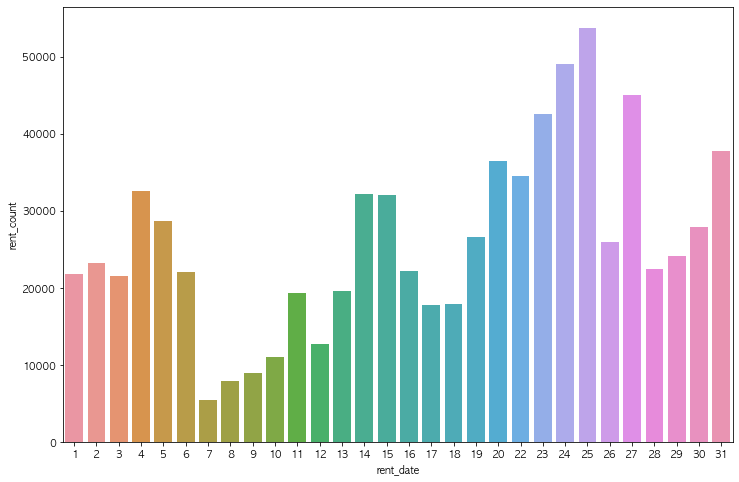

In [19]:
plt.figure(figsize=(12,8))
sns.barplot(x=df.groupby('rent_date')['rent_count'].sum().index.day, y=df.groupby('rent_date')['rent_count'].sum())
plt.show()

### rent_hour

In [20]:
df.groupby('rent_hour')['rent_count'].sum()

rent_hour
0     11906
1      9495
2      6553
3      4741
4      4072
5      5569
6     10883
7     26247
8     49120
9     28765
10    24589
11    33049
12    41142
13    46337
14    52792
15    57265
16    59085
17    67065
18    74547
19    49099
20    41897
21    40793
22    22914
23    14880
Name: rent_count, dtype: int64

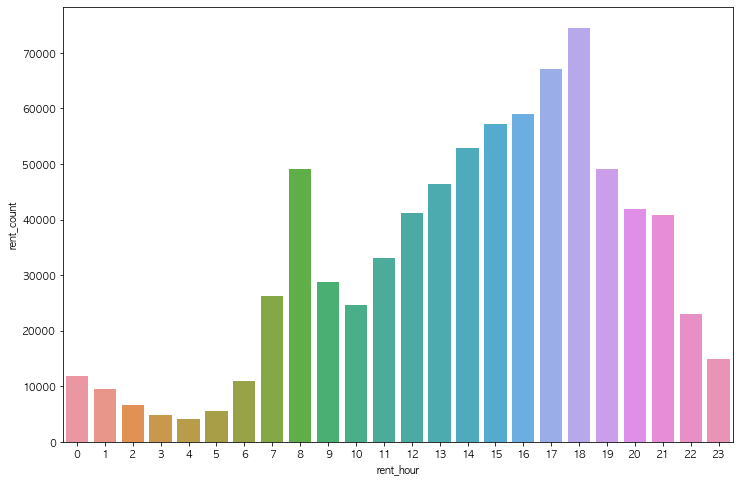

In [21]:
plt.figure(figsize=(12,8))
sns.barplot(x=df.groupby('rent_hour')['rent_count'].sum().index, y=df.groupby('rent_hour')['rent_count'].sum())
plt.show()

### station_no

In [15]:
len(df.station_no.unique())

2188

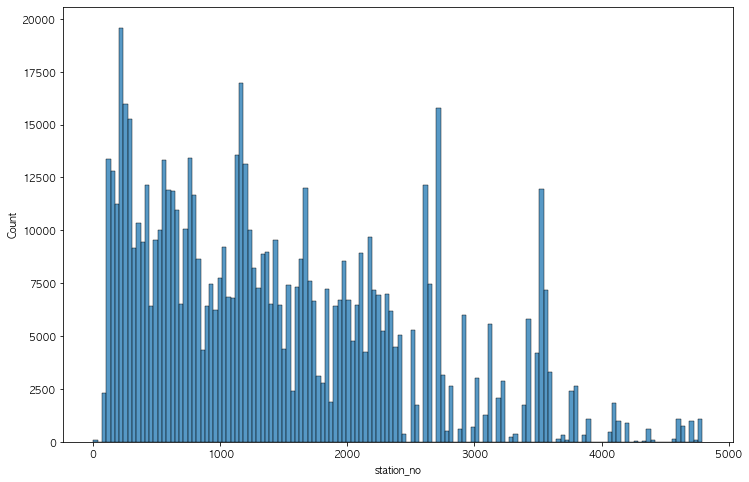

In [154]:
plt.figure(figsize=(12,8))
sns.histplot(df[df.station_no < 5000].station_no)
plt.show()

In [23]:
df.station_no.describe()

count    718857.000000
mean       1447.329716
std        1015.266910
min           3.000000
25%         600.000000
50%        1230.000000
75%        2113.000000
max        9999.000000
Name: station_no, dtype: float64

In [24]:
df[df['station_no'] > 6000]

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour
4313,2021-01-01,11,9999,상담센터,정기권,M,40대,1,2.69,0.02,88.24,4
81304,2021-01-04,17,9997,9997.강남센터,정기권,M,40대,1,0.00,0.00,0.00,11
110109,2021-01-05,17,9997,9997.강남센터,정기권,M,40대,1,0.00,0.00,0.00,20
182997,2021-01-11,17,9997,9997.강남센터,정기권,M,40대,1,0.00,0.00,0.00,25
196318,2021-01-12,11,9997,9997.강남센터,정기권,M,50대,1,0.00,0.00,0.00,52
202826,2021-01-13,8,9980,9980. 에이텍,정기권,F,40대,1,36.04,0.32,1400.00,12
205584,2021-01-13,13,9999,상담센터,정기권,,40대,1,35.86,0.32,1392.98,8
209811,2021-01-13,16,9997,9997.강남센터,정기권,M,40대,1,0.00,0.00,0.00,66
238747,2021-01-14,17,9997,9997.강남센터,정기권,M,40대,1,0.00,0.00,0.00,22
263106,2021-01-15,14,9997,9997.강남센터,정기권,M,40대,1,0.00,0.00,0.00,3


- station_no 별로 지역특성 반영되어있는지 확인 필요

In [9]:
with open('/Users/johanjun/Documents/data/df_station_info_210610.pkl', 'rb') as f:
    df_station_info = pickle.load(f)

In [10]:
df_station_info.head()

,station_no,station_name,station_id,longitude,latitude,SeCd
0,102,102. 망원역 1번출구 앞,ST-4,126.91062927,37.55564880,RAK_001
1,103,103. 망원역 2번출구 앞,ST-5,126.91083527,37.55495071,RAK_001
2,104,104. 합정역 1번출구 앞,ST-6,126.91498566,37.55062866,RAK_001
3,105,105. 합정역 5번출구 앞,ST-7,126.91482544,37.55000687,RAK_001
4,106,106. 합정역 7번출구 앞,ST-8,126.91282654,37.54864502,RAK_001


In [22]:
df_station_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   station_no    2242 non-null   int64 
 1   station_name  2242 non-null   object
 2   station_id    2242 non-null   object
 3   longitude     2242 non-null   object
 4   latitude      2242 non-null   object
 5   SeCd          2242 non-null   object
dtypes: int64(1), object(5)
memory usage: 105.2+ KB


In [28]:
df_station_info.SeCd.value_counts()

RAK_001    1447
RAK_002     795
Name: SeCd, dtype: int64

### 지도 시각화

In [6]:
with open(str(pw_path)+'googlemaps_api_key.pkl', 'rb') as f:
    api_key = pickle.load(f)

In [7]:
gmaps = googlemaps.Client(key=api_key)

In [8]:
gmaps.geocode('망원역 1번출구 앞', language='ko')

[{'address_components': [{'long_name': '４４１−３０',
    'short_name': '４４１−３０',
    'types': ['premise']},
   {'long_name': '서교동',
    'short_name': '서교동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '마포구',
    'short_name': '마포구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '121-210',
    'short_name': '121-210',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 마포구 서교동 441-30',
  'geometry': {'location': {'lat': 37.5559055, 'lng': 126.910363},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.5572544802915,
     'lng': 126.9117119802915},
    'southwest': {'lat': 37.55455651970851, 'lng': 126.9090140197085}}},
  'place_id': 'ChIJX2XBmieZfDURQeMUUIkuM2E',
  'plus_code': {'c

In [25]:
gmaps.geocode('망원역 1번출구 앞', language='ko')

[{'address_components': [{'long_name': '４４１−３０',
    'short_name': '４４１−３０',
    'types': ['premise']},
   {'long_name': '서교동',
    'short_name': '서교동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '마포구',
    'short_name': '마포구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '121-210',
    'short_name': '121-210',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 마포구 서교동 441-30',
  'geometry': {'location': {'lat': 37.5559055, 'lng': 126.910363},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.5572544802915,
     'lng': 126.9117119802915},
    'southwest': {'lat': 37.55455651970851, 'lng': 126.9090140197085}}},
  'place_id': 'ChIJX2XBmieZfDURQeMUUIkuM2E',
  'plus_code': {'c

In [96]:
gmap = folium.Map(location=[37.55564880, 126.91062927], zoom_start=10)
for i in range(len(df_station_info[:100])):
    folium.Marker([(df_station_info['latitude'][i]), (df_station_info['longitude'][i])],
                   popup=df_station_info['station_name'][i],
                   icon=folium.Icon(color='green')).add_to(gmap)
# folium.Marker([126.91062927, 37.55564880], popup='102. 망원역 1번출구 앞').add_to(gmap)
gmap

- geopy

In [39]:
geolocator = Nominatim(user_agent='googlemaps')

In [40]:
location = geolocator.reverse("37.55564880, 126.91062927")

In [41]:
print(location.address)

스타벅스, 74, 월드컵로, 성산1동, 마포구, 서울, 오정구, 04004, 대한민국


In [45]:
geolocator = Nominatim(user_agent='googlemaps')
for i in range(len(df_station_info[:5])):
    loc = geolocator.reverse(df_station_info.latitude[i]+", "+df_station_info.longitude[i])
    print(loc.address)

스타벅스, 74, 월드컵로, 성산1동, 마포구, 서울, 오정구, 04004, 대한민국
기업은행서교동지점 (최규하대통령가옥), 월드컵로11길, 망원1동, 마포구, 서울, 오정구, 04021, 대한민국
합정역 1번출구, 양화로, 서교동, 마포구, 서울, 04045, 대한민국
동양한강트레벨 오피스텔, 56, 양화로, 합정동, 마포구, 서울, 오정구, 04045, 대한민국
CU 합정비젼점, 32, 양화진길, 합정동, 마포구, 서울, 오정구, 04045, 대한민국


In [48]:
address_list

['스타벅스, 74, 월드컵로, 성산1동, 마포구, 서울, 오정구, 04004, 대한민국',
 '기업은행서교동지점 (최규하대통령가옥), 월드컵로11길, 망원1동, 마포구, 서울, 오정구, 04021, 대한민국',
 '합정역 1번출구, 양화로, 서교동, 마포구, 서울, 04045, 대한민국',
 '동양한강트레벨 오피스텔, 56, 양화로, 합정동, 마포구, 서울, 오정구, 04045, 대한민국',
 'CU 합정비젼점, 32, 양화진길, 합정동, 마포구, 서울, 오정구, 04045, 대한민국',
 '따릉이 신한은행 서교동금융센터앞, 월드컵북로5길, 홍대거리, 서교동, 마포구, 서울, 121-869, 대한민국',
 '100, 양화로, 홍대거리, 서교동, 마포구, 서울, 04048, 대한민국',
 '제일빌딩, 어울마당로, 서강동, 마포구, 서울, 04073, 대한민국',
 '상수역 2번출구, 독막로, 서강동, 마포구, 서울, 04067, 대한민국',
 '56, 와우산로, 서강동, 마포구, 서울, 04066, 대한민국']

In [53]:
df_station_info['address'] = None

In [68]:
for i in tqdm(range(len(df_station_info))):
    loc = geolocator.reverse(df_station_info.latitude[i]+", "+df_station_info.longitude[i])
    df_station_info['address'][i] = loc

100%|██████████| 2242/2242 [18:42<00:00,  2.00it/s]


In [83]:
# with open('data/df_station_info(address).pkl', 'wb') as f:
#     pickle.dump(df_station_info, f)

In [12]:
with open('data/df_station_info(address).pkl', 'rb') as f:
    df_station_info = pickle.load(f)

In [13]:
df_station_info.head()

,station_no,station_name,station_id,longitude,latitude,SeCd,address
0,102,102. 망원역 1번출구 앞,ST-4,126.91062927,37.55564880,RAK_001,"(스타벅스, 74, 월드컵로, 성산1동, 마포구, 서울, 오정구, 04004, 대한..."
1,103,103. 망원역 2번출구 앞,ST-5,126.91083527,37.55495071,RAK_001,"(기업은행서교동지점 (최규하대통령가옥), 월드컵로11길, 망원1동, 마포구, 서울,..."
2,104,104. 합정역 1번출구 앞,ST-6,126.91498566,37.55062866,RAK_001,"(합정역 1번출구, 양화로, 서교동, 마포구, 서울, 04045, 대한민국, (37..."
3,105,105. 합정역 5번출구 앞,ST-7,126.91482544,37.55000687,RAK_001,"(동양한강트레벨 오피스텔, 56, 양화로, 합정동, 마포구, 서울, 오정구, 040..."
4,106,106. 합정역 7번출구 앞,ST-8,126.91282654,37.54864502,RAK_001,"(CU 합정비젼점, 32, 양화진길, 합정동, 마포구, 서울, 오정구, 04045,..."


In [15]:
df_station_info_address = df_station_info.loc[:, ['station_no', 'address']]
df_station_info_address.head()

,station_no,address
0,102,"(스타벅스, 74, 월드컵로, 성산1동, 마포구, 서울, 오정구, 04004, 대한..."
1,103,"(기업은행서교동지점 (최규하대통령가옥), 월드컵로11길, 망원1동, 마포구, 서울,..."
2,104,"(합정역 1번출구, 양화로, 서교동, 마포구, 서울, 04045, 대한민국, (37..."
3,105,"(동양한강트레벨 오피스텔, 56, 양화로, 합정동, 마포구, 서울, 오정구, 040..."
4,106,"(CU 합정비젼점, 32, 양화진길, 합정동, 마포구, 서울, 오정구, 04045,..."


In [66]:
df_address_join = pd.merge(df, df_station_info_address, left_on='station_no', right_on='station_no', how='outer', )
df_address_join.head()

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour,address
0,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,~10대,2.0,28.90,0.23,992.78,13.0,"(817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대한민국, (3..."
1,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,20대,1.0,11.24,0.07,283.72,1.0,"(817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대한민국, (3..."
2,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,,20대,1.0,42.24,0.43,1839.04,37.0,"(817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대한민국, (3..."
3,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,20대,2.0,50.75,0.44,1912.72,73.0,"(817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대한민국, (3..."
4,2021-01-01,5.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,~10대,1.0,183.65,1.66,7134.79,47.0,"(817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대한민국, (3..."


In [118]:
df.shape

(718857, 12)

In [119]:
df_address_join.shape

(719093, 13)

In [17]:
#대여소 번호만 있고 다른 정보는 없는 경우
df_address_join_null = df_address_join[df_address_join['rent_date'].isnull()]

In [137]:
df_address_join_null.shape

(236, 13)

In [144]:
df_address_join_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 718857 to 719092
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rent_date     0 non-null      object 
 1   rent_hour     0 non-null      float64
 2   station_no    236 non-null    int64  
 3   station_name  0 non-null      object 
 4   rent_type     0 non-null      object 
 5   sex           0 non-null      object 
 6   age_type      0 non-null      object 
 7   rent_count    0 non-null      float64
 8   momentum      0 non-null      float64
 9   green         0 non-null      float64
 10  distance      0 non-null      float64
 11  use_hour      0 non-null      float64
 12  address       235 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 33.9+ KB


In [146]:
max(df_address_join_null.station_no.value_counts())

1

In [18]:
df_address_join_null['address'] = df_address_join_null['address'].apply(lambda x : str(x).split(','))
df_address_join_null.head()

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour,address
718857,NaN,NaN,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[삼성플라자, 양화로, 홍대거리, 서교동, 마포구, 서울, 03995, ..."
718858,NaN,NaN,1319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[내부순환로, 정릉1동, 성북구, 서울, 노원구, 02735, 대한민국]"
718859,NaN,NaN,1687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Soul Buoy]
718860,NaN,NaN,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[우면치안센터, 바우뫼로9길, 양재1동, 서초구, 서울, 137-140, ..."
718861,NaN,NaN,3603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[432, 영동대로, 대치2동, 강남구, 서울, 06182, 대한민국]"


In [73]:
df_address_join['address'] = df_address_join['address'].apply(lambda x : str(x).split(','))
df_address_join.head()

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour,address,gu
0,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,~10대,2.0,28.90,0.23,992.78,13.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
1,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,20대,1.0,11.24,0.07,283.72,1.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
2,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,,20대,1.0,42.24,0.43,1839.04,37.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
3,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,20대,2.0,50.75,0.44,1912.72,73.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
4,2021-01-01,5.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,~10대,1.0,183.65,1.66,7134.79,47.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None


- 구 이름으로 전처리

In [20]:
gu = """
강남구
강동구
강북구
강서구
관악구
광진구
구로구
금천구
노원구
도봉구
동대문구
동작구
마포구
서대문구
서초구
성동구
성북구
송파구
양천구
영등포구
용산구
은평구
종로구
중구
중랑구
"""

In [21]:
gu_list = gu.split('\n')

In [22]:
gu_list.pop(0)
gu_list.pop(-1)

''

In [54]:
gu_list = [x.strip() for x in gu_list]

In [23]:
gu_list

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [85]:
df_address_join['gu'] = None

In [76]:
def is_gu(n):
    ret = 0
    for i in n:
        if i.strip() in gu_list:
            ret = i.strip()
            break
    return ret

In [78]:
is_gu(df_address_join.address[1])

'성북구'

In [86]:
df_address_join.head()

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour,address,gu
0,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,~10대,2.0,28.90,0.23,992.78,13.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
1,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,20대,1.0,11.24,0.07,283.72,1.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
2,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,,20대,1.0,42.24,0.43,1839.04,37.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
3,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,20대,2.0,50.75,0.44,1912.72,73.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None
4,2021-01-01,5.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,~10대,1.0,183.65,1.66,7134.79,47.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",None


In [80]:
for idx, val in tqdm(enumerate(df_address_join.address)):
    try:
        df_address_join.gu[idx] = is_gu(val)
    except:
        pass

84473it [03:49, 368.29it/s]


KeyboardInterrupt: 

In [87]:
df_address_join['gu'] = [is_gu(x) for x in df_address_join['address']]

In [88]:
df_address_join.head()

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour,address,gu
0,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,~10대,2.0,28.90,0.23,992.78,13.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",성북구
1,2021-01-01,0.0,1347,1347. 길음래미안아파트817동 상가 앞,정기권,,20대,1.0,11.24,0.07,283.72,1.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",성북구
2,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,,20대,1.0,42.24,0.43,1839.04,37.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",성북구
3,2021-01-01,2.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,20대,2.0,50.75,0.44,1912.72,73.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",성북구
4,2021-01-01,5.0,1347,1347. 길음래미안아파트817동 상가 앞,일일권,M,~10대,1.0,183.65,1.66,7134.79,47.0,"[817, 길음로, 길음1동, 성북구, 서울, 노원구, 02720, 대...",성북구


In [92]:
df_address_join.gu.value_counts()

강서구     59796
영등포구    52269
0       47731
송파구     45642
마포구     40252
양천구     36691
노원구     32397
광진구     31721
동대문구    30639
종로구     28180
구로구     26827
성동구     26655
서초구     23619
은평구     22973
강남구     21997
강동구     21913
성북구     20711
관악구     20224
동작구     20039
중랑구     19856
서대문구    16893
중구      16298
용산구     15928
도봉구     14459
강북구     13809
금천구     11574
Name: gu, dtype: int64

### station_name

In [25]:
len(df.station_name.unique())

2188

In [26]:
df.station_name[:10]

0           1347. 길음래미안아파트817동 상가 앞
1                1349. 월계2교 버스정류장 앞
2                 1168. 마곡엠밸리10단지 앞
3                  2619. 석촌고분역 4번출구
4                   536. 행당역 2번출구 앞
5                      192. 연서어린이공원
6    1118. 증미역 3번출구뒤(등촌두산위브센티움오피스텔)
7           1936. 개봉역 1번 출구 자전거보관서쪽
8                1038. 강일 다솜 어린이 공원
9                        1157. 강서구청
Name: station_name, dtype: object

In [53]:
for i in df.station_name[:10]:
    print(i.split('.')[1])

 길음래미안아파트817동 상가 앞
 월계2교 버스정류장 앞
 마곡엠밸리10단지 앞
 석촌고분역 4번출구
 행당역 2번출구 앞
 연서어린이공원
 증미역 3번출구뒤(등촌두산위브센티움오피스텔)
 개봉역 1번 출구 자전거보관서쪽
 강일 다솜 어린이 공원
 강서구청


- 번호 뒤 첫 단어에서 지역적 특성을 추출할 수 있을 듯

### rent_type

In [28]:
df.rent_type.unique()

array(['정기권', '일일권', '단체권', '일일권(비회원)'], dtype=object)

In [29]:
df.rent_type.value_counts()

정기권         585211
일일권         130415
단체권           3224
일일권(비회원)         7
Name: rent_type, dtype: int64

In [30]:
df.groupby('rent_type')['rent_count'].sum().index[0]

'단체권'

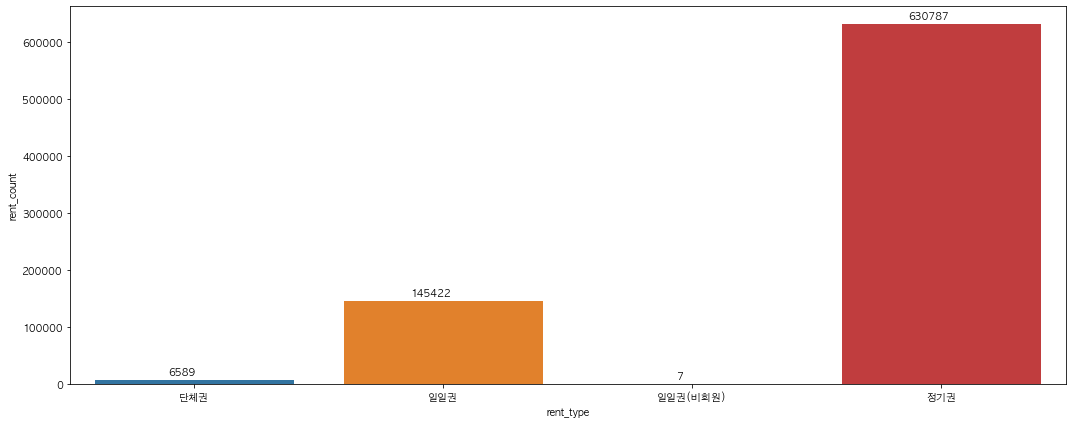

In [92]:
anno = df.groupby('rent_type')['rent_count'].sum()
r = np.arange(len(anno))
width = 0.1


#ref : https://www.pythonpool.com/matplotlib-annotate/
plt.figure(figsize=(15,6))
rects = plt.bar(r - width/2, anno, width)
for rect in rects:
    height = rect.get_height()
    plt.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points", size=10, color="black",
                ha='center', va='bottom')

sns.barplot(x=df.groupby('rent_type')['rent_count'].sum().index,
            y=df.groupby('rent_type')['rent_count'].sum())
plt.tight_layout()
plt.show()

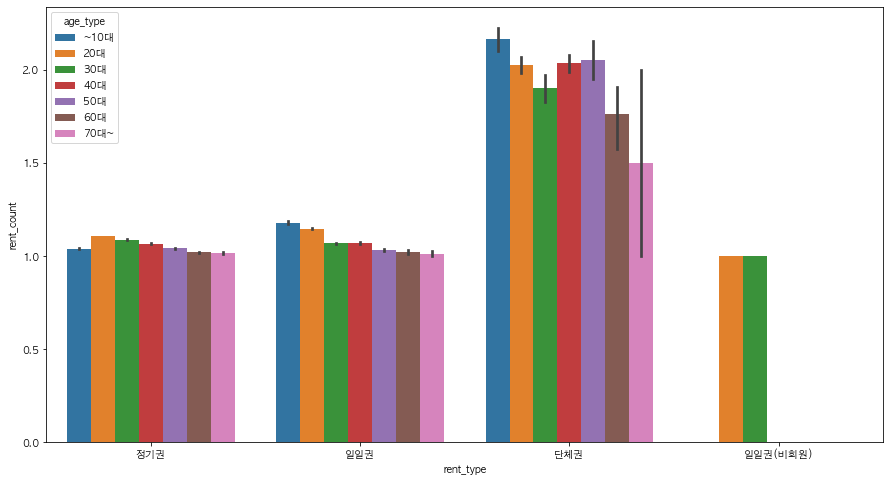

In [32]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.rent_type, y=df.rent_count, hue=df.age_type)
plt.show()

- 단체권의 정의는 무엇일까?
- 연령대가 낮을수록 가격 진입장벽이 낮은 일일권을 많이 구매하고, 연령대가 높을 수록 정기권을 선호함.

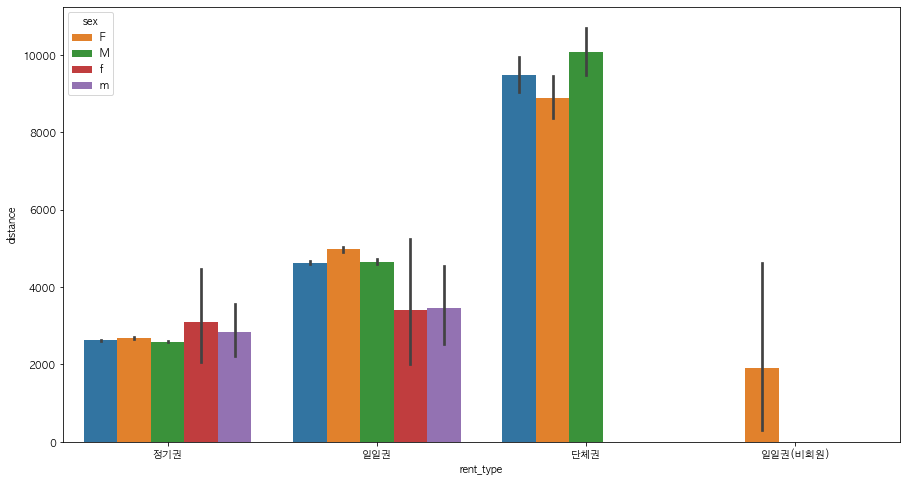

In [33]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.rent_type, y=df.distance, hue=df.sex)
plt.show()

- 성별 데이터 전처리 필요

### sex

In [34]:
df.sex.unique()

array(['', 'F', 'M', 'f', 'm'], dtype=object)

In [35]:
df.sex.value_counts()

     317622
M    262477
F    138500
m       212
f        46
Name: sex, dtype: int64

In [36]:
df.sex.replace('', 'Unknown', inplace=True)
df.sex.replace('m', 'M', inplace=True)
df.sex.replace('f', 'F', inplace=True)

In [37]:
df.sex.value_counts()

Unknown    317622
M          262689
F          138546
Name: sex, dtype: int64

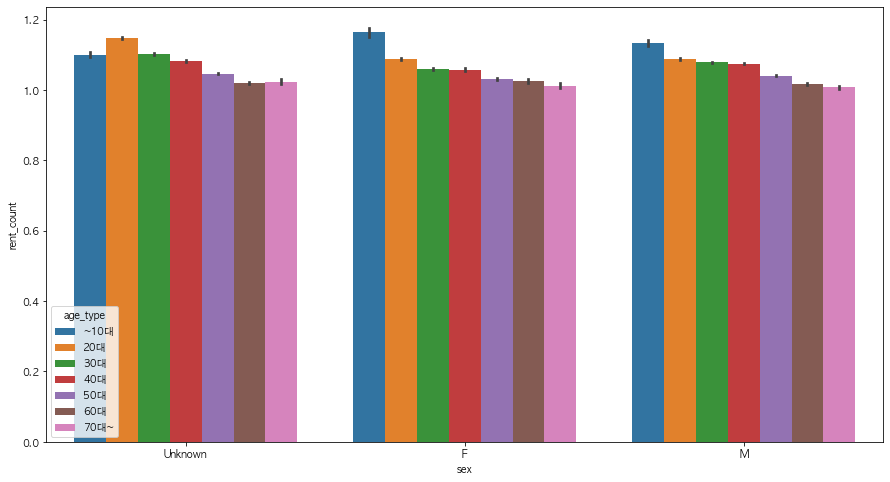

In [38]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.sex, y=df.rent_count, hue=df.age_type)
plt.show()

- Unknown은 어떻게 만들어질까?

### age_type

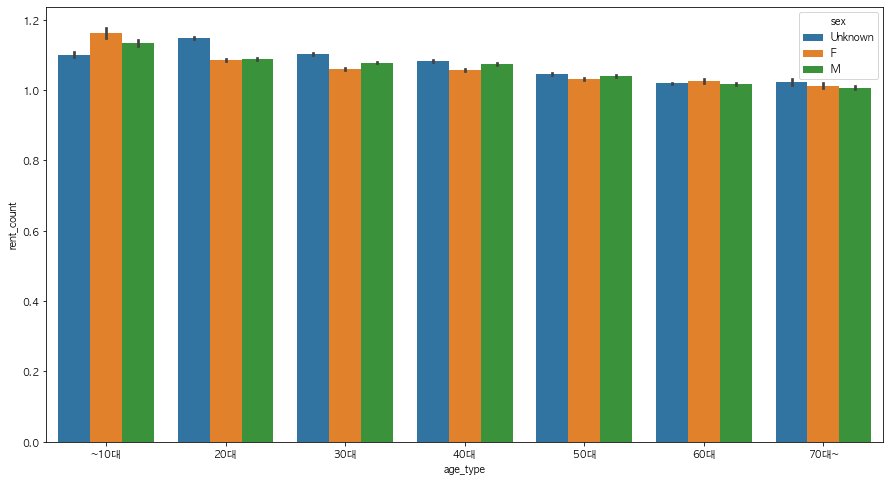

In [43]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.age_type, y=df.rent_count, hue=df.sex)
plt.show()

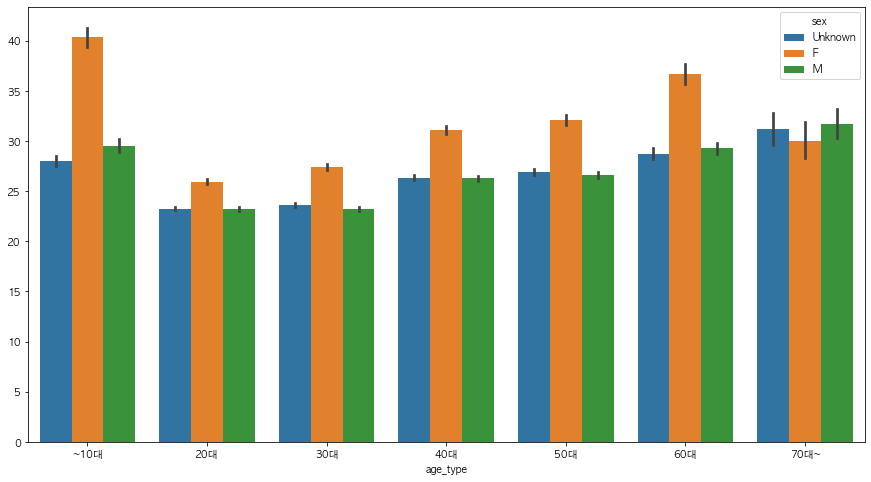

In [119]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.age_type, y=df.use_hour/df.rent_count, hue=df.sex)
plt.show()

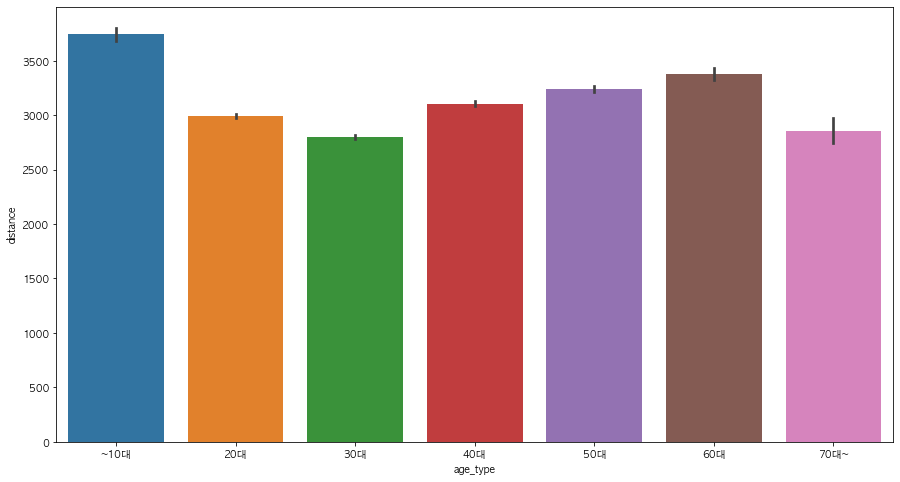

In [75]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.age_type, y=df.distance)
plt.show()

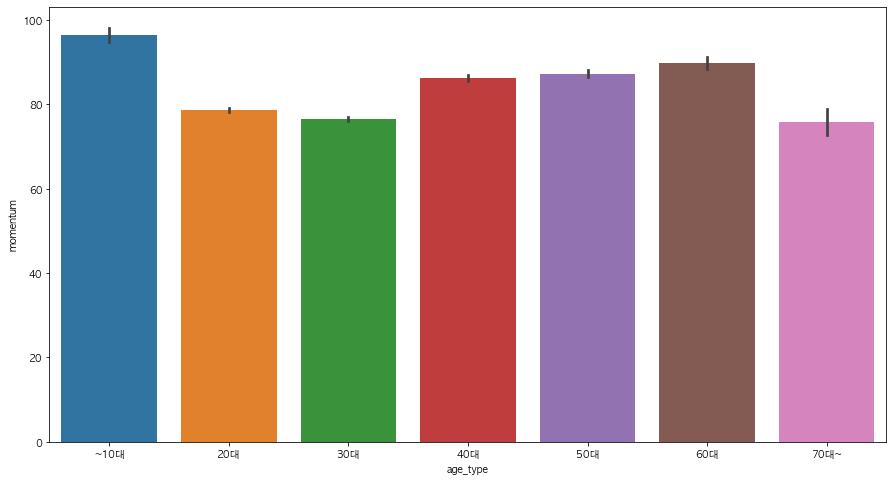

In [73]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.age_type, y=df.momentum)
plt.show()

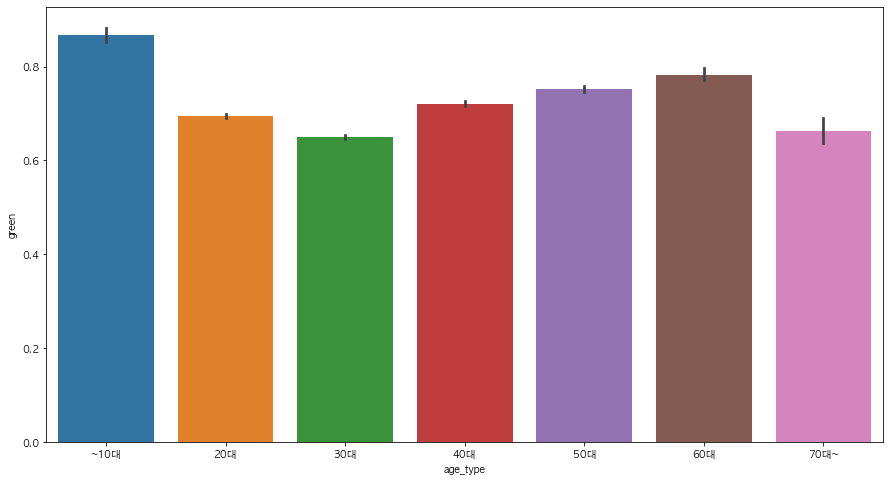

In [74]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.age_type, y=df.green)
plt.show()

In [46]:
df.age_type.describe()

count     718857
unique         7
top          20대
freq      270097
Name: age_type, dtype: object

### rent_count

In [76]:
df.rent_count.describe()

count    718857.000000
mean          1.088958
std           0.339713
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          14.000000
Name: rent_count, dtype: float64

In [87]:
df.rent_count.value_counts()

1     664056
2      47636
3       5773
4       1051
5        231
6         64
7         14
8         11
9          6
10         5
12         3
13         3
11         2
14         2
Name: rent_count, dtype: int64

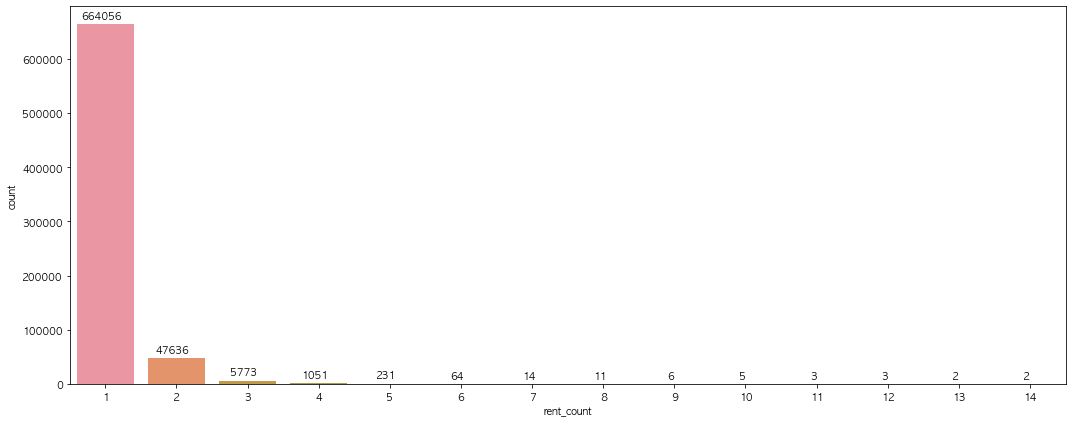

In [90]:
anno = df.rent_count.value_counts()
r = np.arange(len(anno))
width = 0.1


#ref : https://www.pythonpool.com/matplotlib-annotate/
plt.figure(figsize=(15,6))
rects = plt.bar(r - width/2, anno, width)
for rect in rects:
    height = rect.get_height()
    plt.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points", size=10, color="black",
                ha='center', va='bottom')

sns.countplot(x=df.rent_count)
plt.tight_layout()
plt.show()

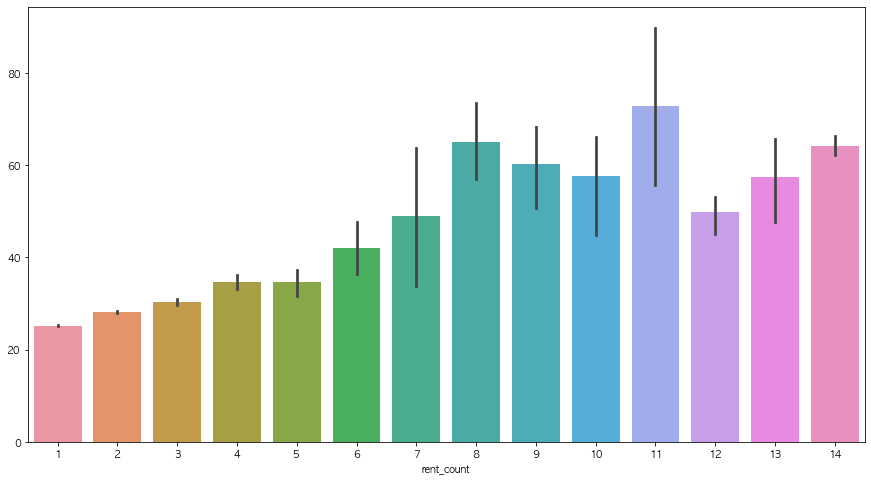

In [118]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.rent_count, y=df.use_hour/df.rent_count)
plt.show()

### momentum

In [123]:
df.momentum.describe()

count    718857.000000
mean         81.531033
std         117.426561
min           0.000000
25%          20.700000
50%          44.680000
75%          95.470000
max        8621.750000
Name: momentum, dtype: float64

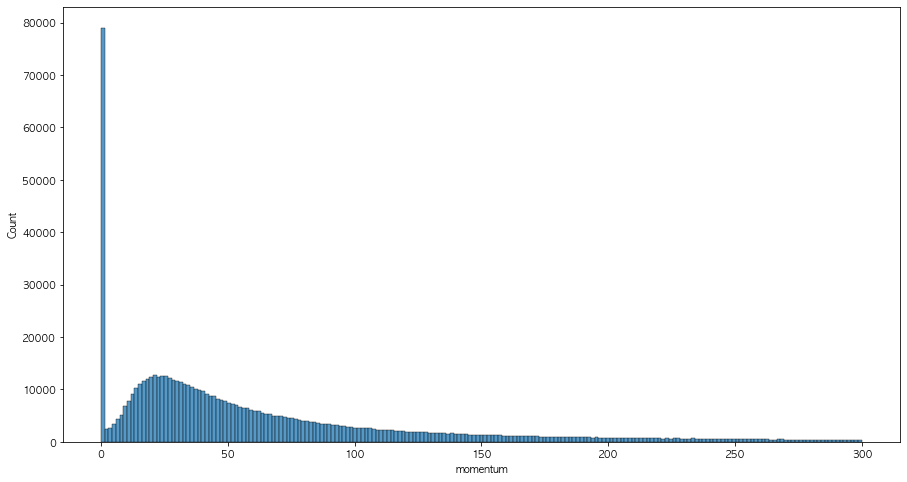

In [138]:
plt.figure(figsize=(15,8))
sns.histplot(data=df[df.momentum < 300].momentum)
plt.show()

In [139]:
df[df.momentum == 0]

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour
2,2021-01-01,0,1168,1168. 마곡엠밸리10단지 앞,정기권,Unknown,~10대,1,0.0,0.0,0.0,7
8,2021-01-01,0,1038,1038. 강일 다솜 어린이 공원,정기권,Unknown,20대,1,0.0,0.0,0.0,11
10,2021-01-01,0,1264,1264. 천호역 10번 출구 앞,정기권,Unknown,20대,1,0.0,0.0,0.0,135
11,2021-01-01,0,1529,1529. 미아동 한국전력공사,정기권,Unknown,20대,1,0.0,0.0,0.0,4
14,2021-01-01,0,3511,3511. 응봉역 1번출구,정기권,Unknown,20대,1,0.0,0.0,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...
718783,2021-01-31,23,3547,3547.상왕십리역 6번 출입구,일일권,M,~10대,1,0.0,0.0,0.0,35
718785,2021-01-31,23,207,207. 여의나루역 1번출구 앞,일일권,M,~10대,1,0.0,0.0,0.0,43
718791,2021-01-31,23,1841,1841. 가산동 주민센터,일일권,M,20대,1,0.0,0.0,0.0,4
718813,2021-01-31,23,1478,1478.홈플러스 상봉점 앞,일일권,M,20대,1,0.0,0.0,0.0,3


- momentum을 계산하는 장치가 고장났다?

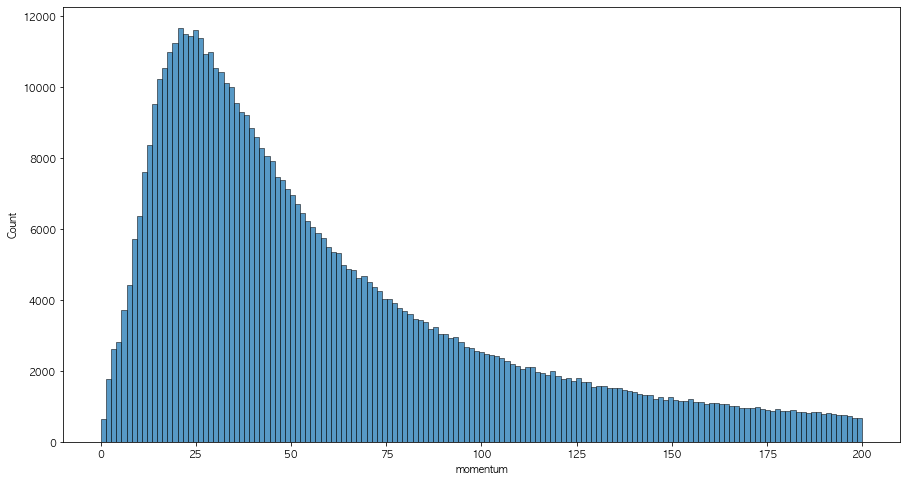

In [151]:
df_momentum = df[df.momentum != 0]

plt.figure(figsize=(15,8))
sns.histplot(data=df_momentum[df_momentum.momentum < 200].momentum)
plt.show()

- 운동량이니까 distance와의 연관은?

In [164]:
df_corr = df.loc[:, ['distance', 'momentum']]
df_corr.head()

,distance,momentum
0,992.78,28.90
1,1127.50,34.38
2,0.00,0.00
3,1658.34,38.75
4,743.88,12.96


In [165]:
df_corr.corr()

,distance,momentum
distance,1.00000,0.97507
momentum,0.97507,1.00000


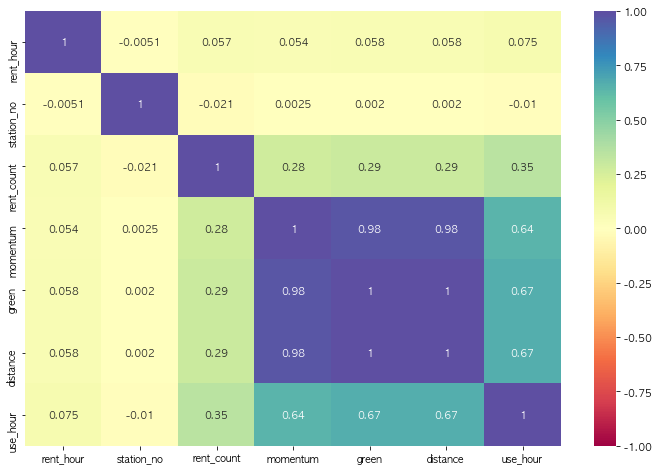

In [167]:
plt.figure(figsize=(12,8))
covMatrix = df.corr()
sns.heatmap(covMatrix, cmap='Spectral', vmin=-1, vmax=1, annot=True, fmt='.2g',)
plt.show()

### green

In [155]:
df.green.describe()

count    718857.000000
mean          0.703856
std           0.993165
min           0.000000
25%           0.180000
50%           0.390000
75%           0.830000
max          57.630000
Name: green, dtype: float64

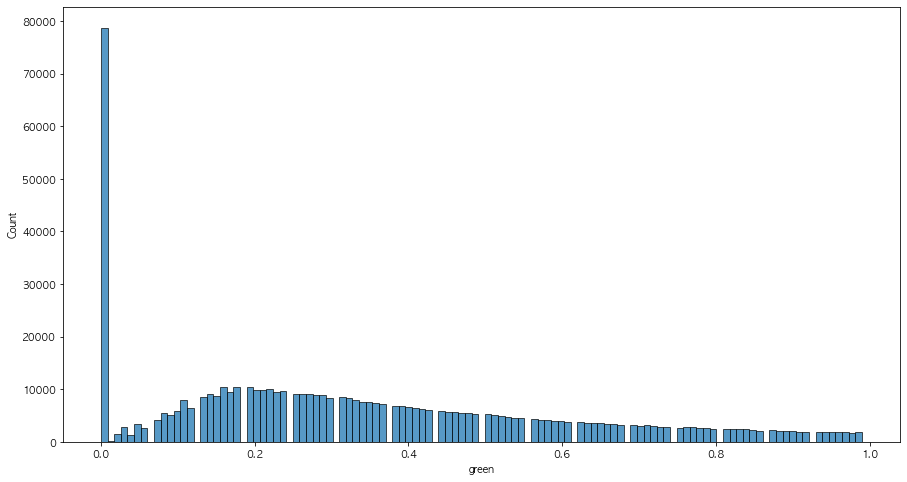

In [158]:
plt.figure(figsize=(15,8))
sns.histplot(data=df[df.green < 1].green)
plt.show()

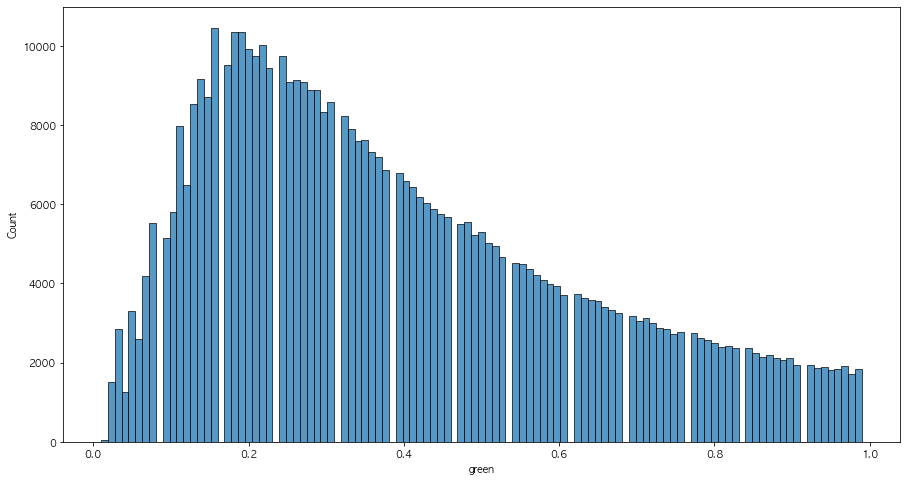

In [186]:
df_green = df[df.green != 0]

plt.figure(figsize=(15,8))
sns.histplot(data=df_green[df_green.green < 1].green)
plt.show()

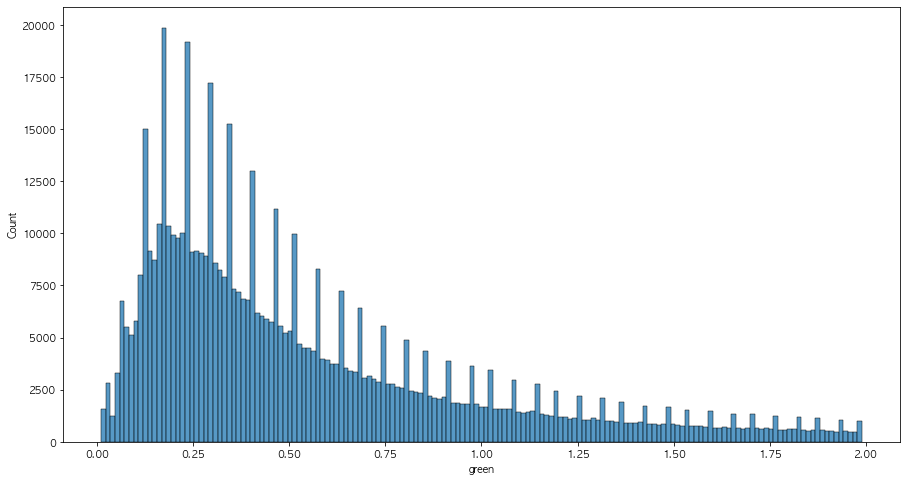

In [187]:
df_green = df[df.green != 0]

plt.figure(figsize=(15,8))
sns.histplot(data=df_green[df_green.green < 2].green)
plt.show()

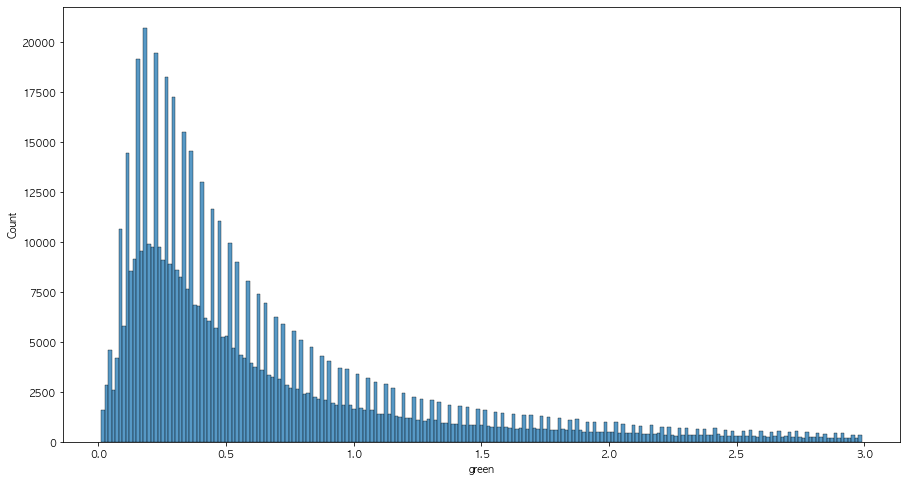

In [188]:
df_green = df[df.green != 0]

plt.figure(figsize=(15,8))
sns.histplot(data=df_green[df_green.green < 3].green)
plt.show()

- 중간중간에 구멍이 규칙적으로 뚫려있다..?

### distance

In [174]:
df.distance.describe()

count    718857.000000
mean       3033.891521
std        4280.828411
min           0.000000
25%         789.020000
50%        1680.000000
75%        3569.610000
max      248420.000000
Name: distance, dtype: float64

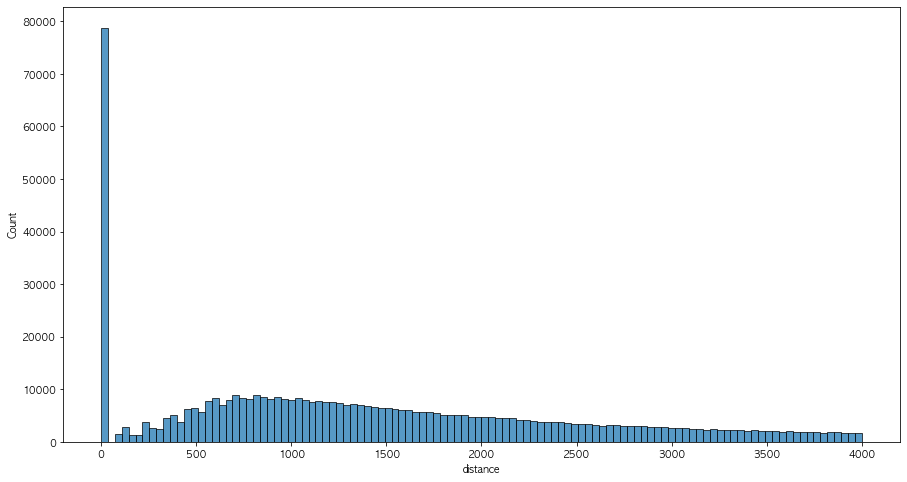

In [178]:
plt.figure(figsize=(15,8))
sns.histplot(data=df[df.distance < 4000].distance)
plt.show()

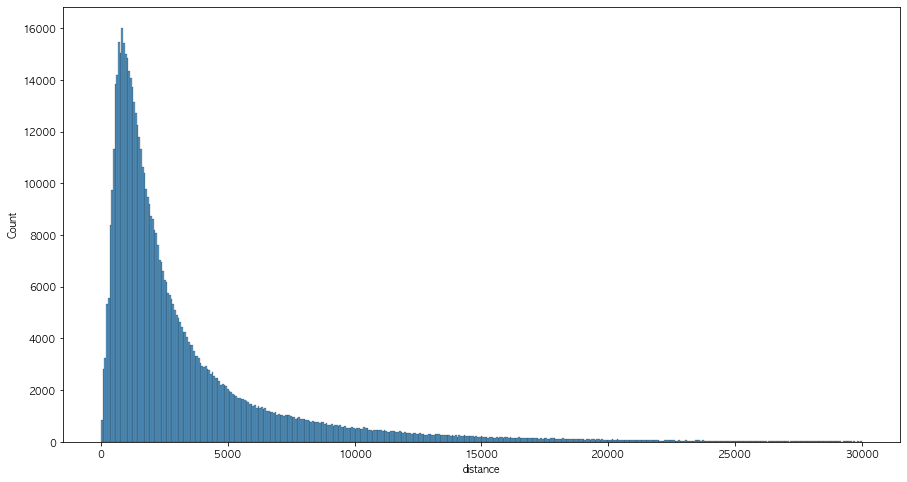

In [183]:
df_distance = df[df.distance != 0]

plt.figure(figsize=(15,8))
sns.histplot(data=df_distance[df_distance.distance < 30000].distance)
plt.show()

### use_hour

In [189]:
df.use_hour.describe()

count    718857.000000
mean         28.062467
std          33.246788
min           0.000000
25%           8.000000
50%          16.000000
75%          37.000000
max        1753.000000
Name: use_hour, dtype: float64

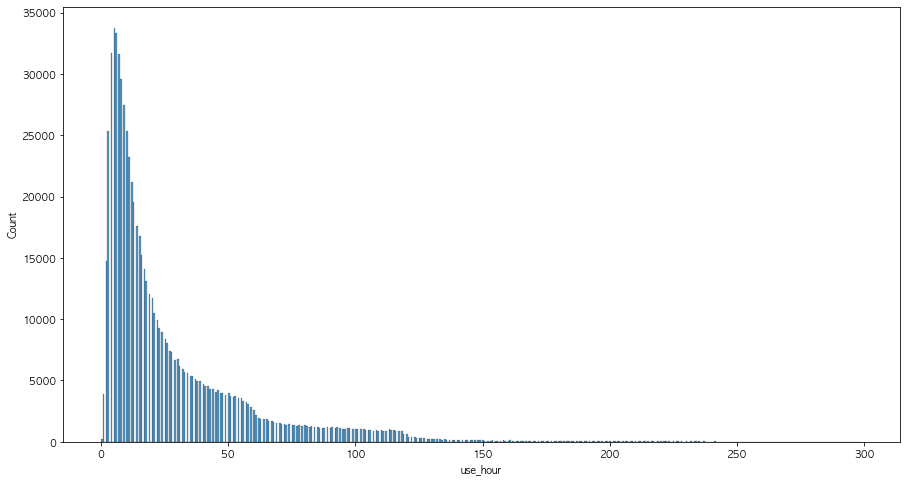

In [191]:
plt.figure(figsize=(15,8))
sns.histplot(data=df[df.use_hour < 300].use_hour)
plt.show()

In [196]:
df_use_0 = df[df.use_hour == 0]
df_use_0[df_use_0.distance != 0]

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour
14431,2021-01-01,17,348,348. 독립문역 사거리,일일권,M,~10대,1,2.27,0.02,88.13,0
17617,2021-01-01,20,3130,3130.가재울사거리,정기권,M,20대,1,3.37,0.03,141.88,0
42069,2021-01-03,0,945,945. 기자촌 사거리,정기권,Unknown,20대,1,3.88,0.03,140.00,0
50336,2021-01-03,14,2089,2089.사당역10번출구(금강빌딩),정기권,M,30대,1,5.54,0.05,200.00,0
60706,2021-01-03,21,3130,3130.가재울사거리,정기권,M,20대,1,2.09,0.02,88.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...
660554,2021-01-30,2,922,922. 연신내역 4번출구,일일권,M,30대,1,2.79,0.03,110.00,0
680104,2021-01-30,19,4617,4617. 동원베네스트 건너편,정기권,M,30대,1,0.00,0.00,0.10,0
696300,2021-01-31,14,526,526. 용답토속공원 앞,정기권,Unknown,20대,1,3.04,0.03,111.20,0
698757,2021-01-31,14,199,199. 서울 월드컵 경기장,일일권,F,30대,1,0.17,0.00,10.00,0


- 빌린 대여는 0 시간인데 주행거리가 있다..? => 혹시 gps기반 이동한 거리에 따라서 distance를 측정한다면 가능(관리자가 옮길 경우)

# preprocessing

In [120]:
df.columns

Index(['rent_date', 'rent_hour', 'station_no', 'station_name', 'rent_type',
       'sex', 'age_type', 'rent_count', 'momentum', 'green', 'distance',
       'use_hour'],
      dtype='object')

In [116]:
df.sample(50)

,rent_date,rent_hour,station_no,station_name,rent_type,sex,age_type,rent_count,momentum,green,distance,use_hour
715024,2021-01-31,20,2716,2716.롯데 R&D 센터,일일권,F,20대,1,0.00,0.00,0.00,15
201064,2021-01-12,21,2372,2372. 대치역 사거리,정기권,Unknown,20대,1,31.20,0.30,1313.06,9
379610,2021-01-20,17,259,259. 대방역6번출구,정기권,M,50대,1,239.27,1.95,8392.05,46
343727,2021-01-19,14,1115,1115. 등촌역 1번출구옆,정기권,F,40대,1,37.12,0.40,1704.47,12
91920,2021-01-04,23,1449,1449. 상봉역 1번출구,일일권,Unknown,20대,1,9.36,0.11,472.76,4
213495,2021-01-13,18,3423,3423.현대그룹(본사),정기권,M,20대,1,17.49,0.13,573.65,4
620788,2021-01-28,8,758,758. 한사랑교회 앞,정기권,Unknown,30대,1,79.70,0.72,3096.29,20
307830,2021-01-17,14,2715,2715.마곡나루역 2번 출구,일일권,M,30대,1,38.62,0.35,1500.36,12
149780,2021-01-08,18,108,108. 서교동 사거리,정기권,Unknown,30대,1,48.91,0.50,2166.95,13
523073,2021-01-25,14,2205,2205. 내곡3단지 어린이공원 앞,일일권,Unknown,30대,1,163.20,1.87,8080.79,79
